In [13]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree, Election
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [14]:
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
print("Loaded graph")


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(309, 320), (307, 320), (308, 309)}
  overlaps
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))


KeyboardInterrupt: 

In [ ]:
print("Sample node data: ")
print(print(graph.nodes[0]))

In [11]:
my_updaters = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "BVAP": updaters.Tally("BLACK_POP", alias="BVAP"),
    "VAP": updaters.Tally("TOT_POP", alias="VAP")
}

elections = [
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"}),
]
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [12]:
PERCENTS = []
counter = 0
for sample in range(0,1000):
    counter += 1
    if counter % 50 == 0:
        print(counter, end=" ")
    district = tree.bipartition_tree(graph, "TOT_POP", ideal_population, 0.02, 2)
    DEMVOTES = sum([graph.nodes[n]["T16PRESD"] for n in district])
    REPVOTES = sum([graph.nodes[n]["T16PRESR"] for n in district])
    PERCENTS.append(DEMVOTES/(DEMVOTES+REPVOTES))

50 

KeyboardInterrupt: 

200 200


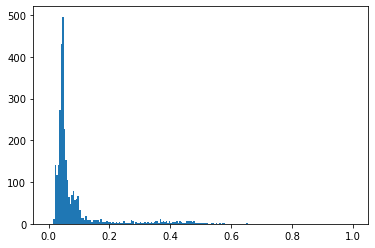

In [30]:
n_bins = 200
hist = plt.hist(PERCENTS, bins=np.linspace(0, 1, n_bins+1, endpoint=True))
pdf = [x/sum(PERCENTS) for x in hist[0]]

In [31]:
class one_district_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

PDF = one_district_pdf()

In [32]:
###MCMC time
vector = list(initial_partition["PRES16"].percents("Democratic"))
print("Starting vector: ", vector)

list_of_vector_dicts = []
counter = 0 
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = BVAPPDF._pdf(proposal[0])*BVAPPDF._pdf(proposal[1])/(BVAPPDF._pdf(vector[position1])*BVAPPDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.04486926398104869, 0.03105268517889877, 0.028254804270462633, 0.020225113052274913, 0.036755774581212645, 0.040445916727828136, 0.045266374988477055, 0.033312124746170055, 0.07336725858724133, 0.023413005934713897, 0.030538123449518007, 0.05137649059620988, 0.04800108917936791, 0.05669159196462904, 0.2147489957847053, 0.17113362873531263, 0.5893275933166027, 0.34225497032262453]


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [9]:
df_real = pd.read_csv("./PA_DEMVOTES/PRES16_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv(
        "./PA_DEMVOTES/PRES16_{0}.csv".format(x), header=None)], ignore_index=True)

Done generating simulated boxplot...
Done generating real boxplot...


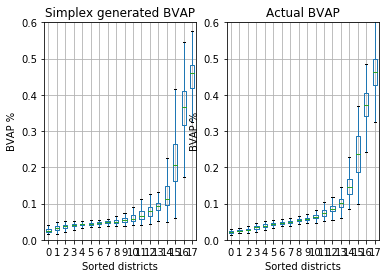

In [33]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated DEM VOTES")
ax.set_ylabel("DEM VOTE %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual DEM VOTES")
ax2.set_ylabel("DEM VOTE %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 0.6)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_PA_demvotes.png")